In [1]:
import json
import yaml
import sys, os
#path2add = os.path.normpath(os.path.abspath(os.path.join(os.path.dirname(__file__), os.path.pardir, 'dir1')))
#print(os.getcwd())
parent_path = os.path.normpath(os.path.abspath(os.path.join(os.getcwd(), os.path.pardir)))
#print(path2add)
sys.path.append(parent_path)
sys.path.append(os.path.normpath(os.path.join(parent_path,"gyrii")))
sys.path.append(os.path.normpath(os.path.join(parent_path,"gyrii","underpinnings")))

from Gyrus import Gyrus

def dict_array_upend(mydict,key,elem):
    if key not in mydict:
        mydict[key]=[]
    mydict[key.append(elem)]

def load_sensor_log_file(fname):
    response=[]
    first_timestamp=0
    f=open(fname,'r')
    for line in f.readlines():        
        dat=json.loads(line)
        timestamp=dat["timestamp"]-first_timestamp
        response.append(dat)
        if first_timestamp==0:                        
            first_timestamp=timestamp
    return response,first_timestamp

#sensor_log1,first_timestamp1=load_sensor_log_file("../to_study/initial_chase_calib.txt")
#sensor_log2,first_timestamp2=load_sensor_log_file("../to_study/random_move_test.txt")
sensor_log,first_timestamp=load_sensor_log_file("../to_study/calibration_motion.txt")

#sensor_log=sensor_log1
#sensor_log.extend(sensor_log2)
#sensor_log,first_timestamp=load_sensor_log_file("../to_study/track_stop_sign.txt")

In [2]:
import torch
from torch.utils.data import Dataset,DataLoader,TensorDataset,random_split
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random
import numpy as np




#Todo: see if I can implement policytrainer as the same as StatePredictor, but with output_state and decision swapped!

#I then need to add the ability to dream

class WeightedLeakyMemoryWithDecision(Dataset):
    def __init__(self,max_len,weight_bounds=[0,1]):
        self.max_len=max_len
        self.weight_bounds=weight_bounds
        self.experiences=[] #[ input_state, decision, target_state, weight]
        self.min_weight=np.inf

    def get_average_weight(self):
        thesum=0
        for x in self.experiences:
            thesum+=x[3]
        return thesum/len(self.experiences)

    def get_average_inv_weight(self):
        thesum=0
        for x in self.experiences:
            thesum+=1/x[3]
        return thesum/len(self.experiences)

    def update_weight(self,index,weight):
        self.experiences[index][3]=weight
        if weight<self.min_weight:
            self.min_weight=weight

    def choose_by_inv_weight(self):
        weights=[ x[3] for x in self.experiences]
        return random.choices(self.experiences, weights=weights)[0]

    def choose_by_weight(self):
        weights=[ 1/x[3] for x in self.experiences]
        return random.choices(self.experiences, weights=weights)[0]

    def forget(self):
        while len(self)>self.max_len:
            self.experiences.remove(self.choose_by_weight())

    def add_experience(self,experience_input,experience_decision,experience_target,weight):
        #your chance of forgetting is propotional to the experience weight
        #only record experience if it has a greater weight than the smallest weights
        if len(self)<self.max_len or weight>self.min_weight:
            if weight<self.min_weight:
                self.min_weight=weight
            self.experiences.append([experience_input,experience_decision,experience_target,weight])
            self.forget()
            return True
        return False

    def get_as_batches(self):
        inp=[]
        dec=[]
        tar=[]
        for i in range(len(self)):
            a,b,c=self[i]
            inp.append(a)
            dec.append(b)
            tar.append(c)
        return torch.stack(inp),torch.stack(dec),torch.stack(tar)

    def __getitem__(self,index):
        return torch.tensor(self.experiences[index][0]).float(),torch.tensor(self.experiences[index][1]).float(),torch.tensor(self.experiences[index][2]).float()

    def __len__(self):
        return len(self.experiences)
    
    
class ScatteredLeakyMemory(Dataset):
    def __init__(self,max_len,input_unc=[],decision_unc=[],output_unc=[]):
        self.max_len=max_len        
        self.experiences=[] #[ input_state, decision, target_state, nearest_neighbor_dist,nearest_neighbor_triple]
        self.input_unc=np.array(input_unc)
        self.decision_unc=np.array(decision_unc)
        self.final_unc=np.array(output_unc)
        
    def add_experience(self,initial,decision,final,forget=True):
        min_dist=np.inf
        elem=[initial,decision,final]
        #print("elem is {}".format(elem))
        for x in self.experiences:
            #print("initial {}".format(final))
            #print("input_unc {}".format(self.final_unc))
            #print("xzero {}".format(x[1]))
            #dist=np.sum(((np.array(initial)-np.array(x[0]))/self.input_unc)**2)+np.sum(((np.array(decision)-np.array(x[1]))/self.decision_unc)**2)+np.sum(((np.array(final)-np.array(x[3]))/self.final_unc)**2)            
            dist=np.sum(((np.array(initial)-np.array(x[0]))/self.input_unc)**2)+np.sum(((np.array(decision)-np.array(x[1]))/self.decision_unc)**2)+np.sum(((np.array(final)-np.array(x[2]))/self.final_unc)**2)
            #print("dist {} to {}".format(dist))
            #print("dist is {}".format(dist))
            if dist<x[3]:  #if I'm adding something closer, update that
                x[3]=dist
            if dist<min_dist:
                min_dist=dist
                elem=[x[0],x[1],x[2]]                    
        self.experiences.append([ initial,decision,final,min_dist,elem])
        if forget:
            todel=self.forget()
            if todel is not None and todel[0:3]==elem:
                return False
        return True
        
    def get_as_batches(self):
        inp=[]
        dec=[]
        tar=[]
        for i in range(len(self)):
            a,b,c=self[i]
            inp.append(a)
            dec.append(b)
            tar.append(c)
        return torch.stack(inp),torch.stack(dec),torch.stack(tar)
    
    def forget(self):        
        if len(self)>self.max_len:
            toresort=[]
            dists=[ x[3] for x in self.experiences ]
            min_ind=dists.index(min(dists))            
            todel=self.experiences.pop(min_ind)            
            for x in self.experiences:
                if x[4][0]==todel[0] and x[4][1]==todel[1] and x[4][2]==todel[2]:
                    toresort.append([ x[0],x[1],x[2] ])
                    self.experiences.remove(x)
            for x in toresort:
                self.add_experience(x[0],x[1],x[2],forget=False)
            return todel
        return None

    def __getitem__(self,index):
        return torch.tensor(self.experiences[index][0]).float(),torch.tensor(self.experiences[index][1]).float(),torch.tensor(self.experiences[index][2]).float()

    def __len__(self):
        return len(self.experiences)    


def weighted_mse_loss(inputs, target, weight):
    #print("weight shape {}".format(weight.shape))
    #print("input shape {}".format(inputs.shape))
    #print("target shape {}".format(target.shape))
    return torch.sum( ( (inputs - target)/weight ) ** 2)

class StatePredictorWithPolicy:

    def __init__(self,predictor,policy,loss_bounds=[1,100],decision_bounds=[ [-1,1] ],memory_size=64,input_unc=None,decision_unc=None,output_unc=None):
        #predictor is a module that given in input state and action state, predicts the output state
        self.predictor=predictor
        self.policy=policy
        self.input_unc=torch.tensor(input_unc)
        self.output_unc=torch.tensor(output_unc)
        self.decision_unc=torch.tensor(decision_unc)
        self.experience_memory=ScatteredLeakyMemory(memory_size,input_unc=input_unc,decision_unc=decision_unc,output_unc=output_unc)
        self.loss_bounds=loss_bounds
        self.decision_bounds=decision_bounds  #array of [min,max]
        self.train_batch_size=64
        self.train_epochs=64
        self.fresh_memories=0
        
        self.target_bounds=[ [-2.0,2.0],[-1.0,1.0] ]
      
    def fantasy_train_policy(self):
        #generate a bunch of scenarios from real starting points, but with different targets                
        loader=DataLoader(self.experience_memory,batch_size=64,shuffle=True)
        optimizer = optim.Adam(self.policy.parameters(), lr=0.01)
        for epoch in range(self.train_epochs):
            for inputs,decisions,targets in loader:     
                #generate new target here
                new_targets=[]
                for i in range(targets.shape[0]):
                    newtarget=[]
                    for d in self.target_bounds:
                        newtarget.append(random.uniform(d[0],d[1]))
                    new_targets.append(torch.tensor(newtarget))
                new_targets=torch.stack(new_targets)                
                
                #the_input=torch.cat( (inputs,targets),1)
                the_input=torch.cat( (inputs,new_targets),1)
                policy_out=self.policy(the_input)
                predicted_out=self.predictor( torch.cat( (inputs,policy_out),1))
                loss=weighted_mse_loss(predicted_out,new_targets,self.output_unc)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
        

    def loss_to_weight(self,loss):
        return 1/np.clip(loss,self.loss_bounds[0],self.loss_bounds[1])

    def predict_output(self,input_state,decision):
        function_input=[ *input_state,*decision]
        predicted_output=self.predictor(torch.unsqueeze(torch.tensor(function_input).float(),0))[0]
        return predicted_output.detach().numpy()    
    
    def predict_decision(self,input_state,output_state):
        function_input=[ *input_state,*output_state]
        predicted_output=self.policy(torch.unsqueeze(torch.tensor(function_input).float(),0))[0]
        return predicted_output.detach().numpy()    

    def observe(self,input_state,decision,output_state):
        with torch.set_grad_enabled(False):
            #loss_function = torch.nn.MSELoss()
            motion_function_input=[ *input_state,*decision]
            decision_function_input=[ *input_state, *output_state]            
            predicted_output=self.predictor(torch.unsqueeze(torch.tensor(motion_function_input).float(),0))[0]
            predicted_decision=self.policy(torch.unsqueeze(torch.tensor(decision_function_input).float(),0))[0]
            output_loss=weighted_mse_loss(predicted_output,torch.tensor(output_state).float(),self.output_unc)
            decision_loss=weighted_mse_loss(predicted_decision,torch.tensor(decision).float(),self.decision_unc)
            loss=(output_loss+decision_loss).item()            
        #if self.experience_memory.add_experience(input_state,decision,output_state,self.loss_to_weight(loss)):
        if self.experience_memory.add_experience(input_state,decision,output_state):
            self.fresh_memories+=1

#    def decide_random(self,input_state):
#        my_decision=[]
#        for d in self.decision_bounds:
#            my_decision.append(random.uniform(d[0],d[1]))
#        return my_decision

 #   def decide_by_probing(self,input_state,desired_output_state,pts_per_dim):
#        pts=[ input_state ]
#        for i in range(len(self.decision_bounds)):
#            toadd=np.linspace(self.decision_bounds[i][0],self.decision_bounds[i][1],pts_per_dim)
#            newpts=[]
#            for i in range(len(toadd)):
#                for j in range(len(pts)):
#                    newpts.append( [*(pts[j]),toadd[i]] )
#            pts=newpts
#        inputs=torch.tensor(pts).float()
#        predictions=self.predictor(inputs)
#        loss_function = torch.nn.MSELoss()
#        best_inv_loss=0
#        best_index=0
#        for i in range(predictions.shape[0]):
#            loss=loss_function(predictions[i],torch.tensor(desired_output_state).float())
            #print("action {} loss {}".format(inputs[i],loss))
#            if 1/loss > best_inv_loss:
#                best_index=i
#                best_inv_loss=1/loss
#        return pts[best_index][len(input_state):]

    def train(self):
        self.train_decision_predictor()
        self.train_motion_predictor()
        self.fresh_memories=0

        #self.reweight_memory()
        
    def reweight_memory(self):
        loss_function = torch.nn.MSELoss()
        with torch.set_grad_enabled(False):
            inputs,decisions,targets=self.experience_memory.get_as_batches()
            predictor_out=self.predictor( torch.cat( (inputs,decisions),1) )
            policy_out=self.policy( torch.cat( (inputs,targets),1))
            for i in range(len(self.experience_memory)):
                output_loss=weighted_mse_loss(predictor_out,targets,self.output_unc)
                decision_loss=weighted_mse_loss(policy_out,decisions,self.decision_unc)
                loss=(output_loss+decision_loss).item()
                self.experience_memory.update_weight(i,self.loss_to_weight(loss))            
        self.fresh_memories=0


    def train_decision_predictor(self):
        print("training")
        loader=DataLoader(self.experience_memory,batch_size=64,shuffle=True)
        #loss_function = torch.nn.MSELoss()
        optimizer = optim.Adam(self.policy.parameters(), lr=0.01)
        for epoch in range(self.train_epochs):
            for inputs,decisions,targets in loader:               
                the_input=torch.cat( (inputs,targets),1)             
                out=self.policy( the_input )
                #loss=loss_function(out,decisions )
                loss=weighted_mse_loss(out,decisions,self.decision_unc)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                        
        
    def train_motion_predictor(self):
        loader=DataLoader(self.experience_memory,batch_size=64,shuffle=True)
        #loss_function = torch.nn.MSELoss()
        optimizer = optim.Adam(self.predictor.parameters(), lr=0.01)
        for epoch in range(self.train_epochs):
            for inputs,decisions,targets in loader:
                the_input=torch.cat( (inputs,decisions),1)
                
                out=self.predictor( the_input )
                #loss=loss_function(out,targets )
                loss=weighted_mse_loss(out,targets,self.output_unc)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
        #now recalculate everything in memory
        #with torch.set_grad_enabled(False):
            #inputs,targets=self.experience_memory.get_as_batches()
            #out=self.predictor( inputs )
            #for i in range(len(self.experience_memory)):
#                self.experience_memory.update_weight(i,self.loss_to_weight(loss_function(out[i],targets[i]).item()))
 #       self.fresh_memories=0
#        return loss_function(out,targets).item()/len(self.experience_memory)

    

In [3]:
from Gyrus import ThreadedGyrus
from NNCalibration import StatePredictor
import torch
import torch.nn as nn
import numpy as np


class VisualMotionCalibGyrus(ThreadedGyrus):
    def __init__(self,broker):
        
        #self.motionpredictor=nn.Sequential(nn.Linear(5,5),
                              #nn.Tanh(),
                              #nn.Linear(5,2))
        
        self.policy=nn.Sequential(nn.Linear(4,4),
                                  nn.Tanh(),
                                  nn.Linear(4,2),
                                  nn.Tanh())
        self.motionpredictor=nn.Sequential(nn.Linear(4,2,bias=False))
        #self.policy=nn.Sequential(nn.Linear(4,3,bias=False))        
        decision_bounds=[ [-0.8,0.8], [-0.8,0.8], [0.1,0.5]] 
        #self.state_predictor=StatePredictor(self.motionpredictor,decision_bounds=decision_bounds,memory_size=128)
        self.state_predictor=StatePredictorWithPolicy(self.motionpredictor,self.policy,decision_bounds=decision_bounds,memory_size=128,input_unc=[0.01,0.1],output_unc=[0.01,0.1],decision_unc=[0.02,0.02])        
                       
        #constants
        self.min_update_interval=0.1 #don't record experiences more than this often     
        self.objects_to_watch=["sports ball","stop sign","chair"]
        self.object_heights={ "stop sign": [0.081,0.005], "sports ball": [0.115,0.01], "chair": [1.0,0.5]}

        self.fresh_memories_to_train=16
        self.camera_focal_length_pixels=630 #V1 raspicam
        self.camera_x_pixels=640
        self.camera_y_pixels=480


        #scales of things
        #self.position_scale=640
        
        #temporary storage
        self.last_unique_objects={}
        self.last_gyro_z=[0,0] #value, stdev
        self.last_motors_active=[1,1] #left, right
        self.last_frame_motion_command=[0,0,0] #left,right, duration
        self.next_update_time=0
        self.last_motor_command={}

        #debugging storage
        self.all_input_vectors=[]
        self.all_target_vectors=[]
        self.all_decision_vectors=[]

        super().__init__(broker)
        
    def get_keys(self):
        return [ "drive/motors_active","position_sensor/gyro", "tagged_objects", "motor_command", "clock_pulse" ]

    def get_name(self):
        return "VisualMotionCalibGyrus"

    def holding_still(self,timestamp): #return true if I think I'm holding still
        if abs(self.last_gyro_z[0])> 0.05 or abs(self.last_gyro_z[0])>0.05:
            return False
        if self.last_motors_active[0]!=0 or self.last_motors_active[1]!=0:
            return False
        if timestamp<self.next_update_time:
            return False
        return True
    
    def get_unique_tagged_objects(self,tagged_objects):
        ret={}
        label_list=[ x["label"] for x in tagged_objects]
        for key in self.objects_to_watch:
            if label_list.count(key)>1 or label_list.count(key)==0:
                continue
            elem=next(filter(lambda x: x["label"]==key,tagged_objects))
            ret[key]=elem
        return ret
            
    
    def read_message(self,message):
        
        if "clock_pulse" in message:
            #don't think about training if not holding still
            if not self.holding_still(message["timestamp"]):
                return 
            if self.state_predictor.fresh_memories>self.fresh_memories_to_train:
                self.state_predictor.train()
                #print("training")
        if "motion_request" in message:
            m=message["motion_request"]
            if m["motion_type"]=="turn":
                input_vector=[m["from_angle"]]
                output_vector=[m["to_angle"]]
                decision=self.state_predictor.decide_by_probing(input_vector,output_vector,10)                
                self.last_motor_command={"timestamp": time.time(),"motor_command": {"lr_throttle": [decision[0],decision[1]], "duration":decision[2] } }                                      
                #broker.publish({"timestamp": time.time(),"motor_command": {"lr_throttle": [decision[0],decision[1]], "duration":decision[2] } },"motor_command")                                        
        if "position_sensor/gyro" in message:
            gyro_z=message["position_sensor/gyro"][2]
            gyro_z_stdev=message["position_sensor/gyro_stdev"][2]
            self.last_gyro_z=[gyro_z,gyro_z_stdev]
        if "drive/motors_active" in message:
            left_motor=message["drive/motors_active"][0]
            right_motor=message["drive/motors_active"][1]
            self.last_motors_active=[left_motor,right_motor]
        if "motor_command" in message:
            m=message["motor_command"]
            if m["lr_throttle"][0] or m["lr_throttle"][1]!=0:
                #self.last_motion_time=message["timestamp"]
                self.last_frame_motion_command=[ m["lr_throttle"][0],m["lr_throttle"][1],m["duration"]]
                self.next_update_time=message["timestamp"]+m["duration"]
        if "tagged_objects" in message:
            #only check if holding still
            if not self.holding_still(message["timestamp"]):
                return 
            unique_objects=self.get_unique_tagged_objects(message["tagged_objects"])
            for key in unique_objects:
                if key in self.last_unique_objects:
                    #exists in both this and last set
                    obj_height=self.object_heights[key][0]
                    
                    #get 'center of mass' x f
                    prev_startx=self.last_unique_objects[key]["startx"]
                    prev_endx=self.last_unique_objects[key]["endx"]
                    prev_starty=self.last_unique_objects[key]["starty"]
                    prev_endy=self.last_unique_objects[key]["endy"]
                    #prev_x=0.5*(prev_startx+prev_endx)
                    next_startx=unique_objects[key]["startx"]
                    next_endx=unique_objects[key]["endx"]
                    next_starty=unique_objects[key]["starty"]
                    next_endy=unique_objects[key]["endy"]
                    #next_x=0.5*(next_startx+next_endx)
                    
                    startx_cut=5
                    endx_cut=self.camera_x_pixels-startx_cut
                    starty_cut=5
                    endy_cut=self.camera_y_pixels-starty_cut
                    
                    #I have to have some notion of distance from object
                    if prev_starty>starty_cut and next_starty>starty_cut and prev_endy<endy_cut and next_endy<endy_cut:
                        #hpx / focal = height/dist
                        # dist = focal * (height) / hpx
                        #TODO far future, I could make the object hight per class a free parameter that is fit.  Ha!
                        #print("height {}".format(obj_height))
                        prev_objdist=obj_height*self.camera_focal_length_pixels/(prev_endy-prev_starty)
                        next_objdist=obj_height*self.camera_focal_length_pixels/(next_endy-next_starty)
                        delta_dist=next_objdist-prev_objdist
                        startx_good=prev_startx>startx_cut and next_startx>startx_cut
                        endx_good=prev_endx<endx_cut and next_endx<endx_cut                        
                        if startx_good and endx_good:
                            prev_heading=np.arctan(  0.5*(prev_startx+prev_endx-self.camera_x_pixels/2)/self.camera_focal_length_pixels )
                            next_heading=np.arctan(  0.5*(next_startx+next_endx-self.camera_x_pixels/2)/self.camera_focal_length_pixels )                            
                        elif startx_good and not endx_good:
                            prev_heading=np.arctan(  (prev_startx-self.camera_x_pixels/2)/self.camera_focal_length_pixels )
                            next_heading=np.arctan(  (next_startx-self.camera_x_pixels/2)/self.camera_focal_length_pixels )                                                        
                        elif endx_good and not startx_good:
                            prev_heading=np.arctan(  (prev_endx-self.camera_x_pixels/2)/self.camera_focal_length_pixels )
                            next_heading=np.arctan(  (next_endx-self.camera_x_pixels/2)/self.camera_focal_length_pixels )                                                        
                        else: #neither are good
                            continue
                        delta_heading=next_heading-prev_heading
                        last_input_vector=[ prev_heading,prev_objdist ]
                        #decision_vector=self.last_frame_motion_command
                        decision_vector=[self.last_frame_motion_command[0],self.last_frame_motion_command[1]]
                        target_vector=[ delta_heading,delta_dist ]
                        self.state_predictor.observe(last_input_vector,decision_vector,target_vector)
                        self.all_input_vectors.append(last_input_vector)
                        self.all_decision_vectors.append(decision_vector)
                        self.all_target_vectors.append(target_vector)
                 
            self.last_unique_objects=unique_objects
            self.last_frame_motion_command=[0,0,0]
            self.next_update_time=message["timestamp"]+self.min_update_interval
            
from tqdm import tqdm
import time
vmgyrus=VisualMotionCalibGyrus(None)
for message in tqdm(sensor_log):
    vmgyrus.read_message(message)
    
    vmgyrus.read_message({"timestamp": time.time(),"clock_pulse": 0.1})

  2%|█▍                                                                             | 54/3058 [00:00<00:08, 334.30it/s]

training
training


  3%|██▍                                                                            | 92/3058 [00:00<00:10, 284.16it/s]

training


  4%|███▎                                                                          | 129/3058 [00:00<00:12, 226.63it/s]

training


  6%|████▍                                                                         | 174/3058 [00:00<00:15, 185.79it/s]

training


  7%|█████▌                                                                        | 218/3058 [00:01<00:18, 153.81it/s]

training


  9%|███████▎                                                                      | 287/3058 [00:01<00:18, 150.98it/s]

training


 14%|██████████▊                                                                   | 425/3058 [00:02<00:16, 159.69it/s]

training


 16%|████████████▎                                                                 | 481/3058 [00:03<00:24, 103.78it/s]

training


 18%|██████████████▌                                                                | 562/3058 [00:04<00:25, 97.74it/s]

training


 21%|████████████████▋                                                             | 656/3058 [00:04<00:21, 112.69it/s]

training


 26%|████████████████████▌                                                         | 805/3058 [00:05<00:13, 167.39it/s]

training


 29%|██████████████████████▎                                                       | 877/3058 [00:06<00:16, 130.45it/s]

training


 32%|████████████████████████▊                                                     | 971/3058 [00:07<00:15, 135.56it/s]

training


 35%|███████████████████████████                                                  | 1076/3058 [00:07<00:14, 140.28it/s]

training


 38%|█████████████████████████████▍                                               | 1167/3058 [00:08<00:13, 135.59it/s]

training


 45%|██████████████████████████████████▋                                          | 1379/3058 [00:09<00:07, 224.19it/s]

training


 51%|███████████████████████████████████████▍                                     | 1568/3058 [00:09<00:05, 253.85it/s]

training


 57%|███████████████████████████████████████████▊                                 | 1740/3058 [00:10<00:04, 263.83it/s]

training


 62%|███████████████████████████████████████████████▌                             | 1889/3058 [00:11<00:04, 234.16it/s]

training


 71%|██████████████████████████████████████████████████████▊                      | 2176/3058 [00:11<00:02, 338.60it/s]

training


 79%|█████████████████████████████████████████████████████████████                | 2426/3058 [00:12<00:01, 377.44it/s]

training


 91%|█████████████████████████████████████████████████████████████████████▋       | 2768/3058 [00:13<00:00, 459.25it/s]

training


100%|█████████████████████████████████████████████████████████████████████████████| 3058/3058 [00:14<00:00, 213.31it/s]


In [4]:
print(len(vmgyrus.state_predictor.experience_memory))

128


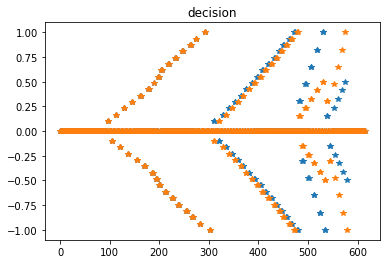

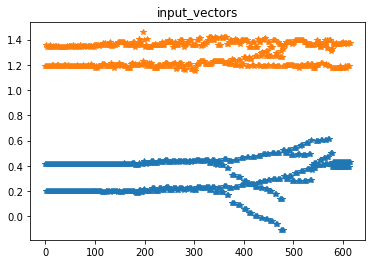

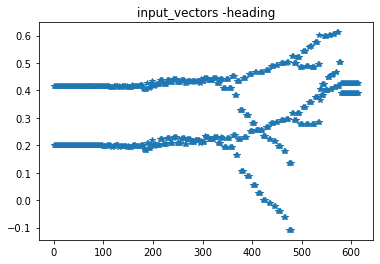

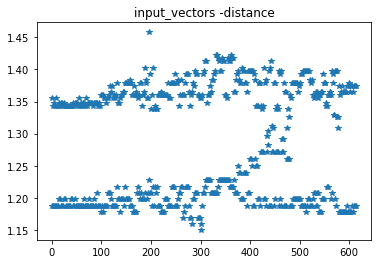

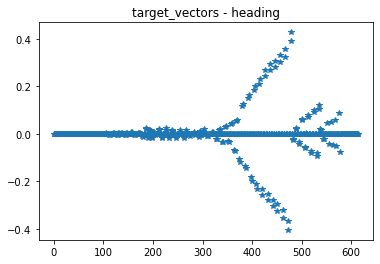

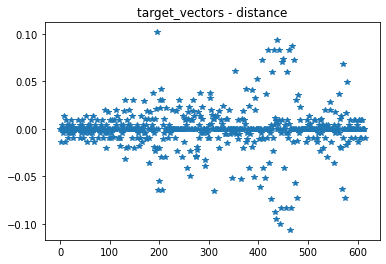

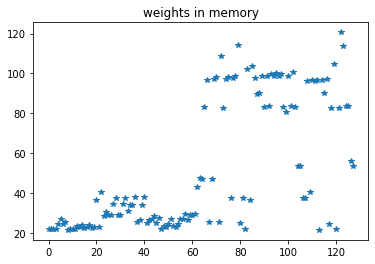

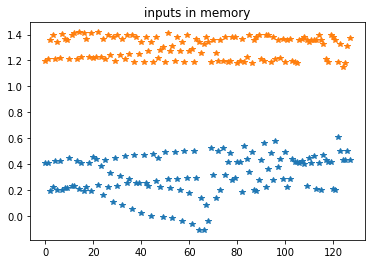

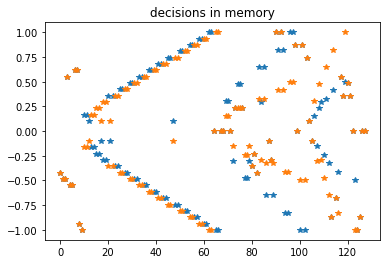

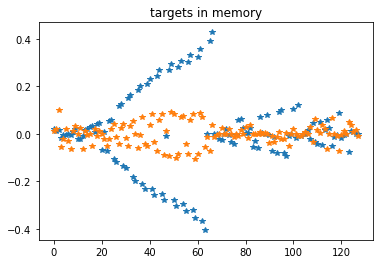

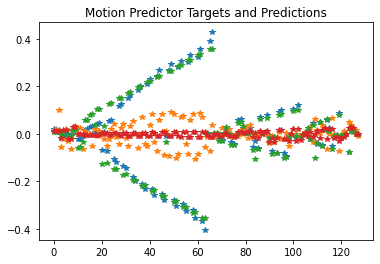

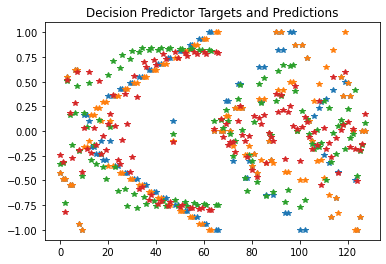

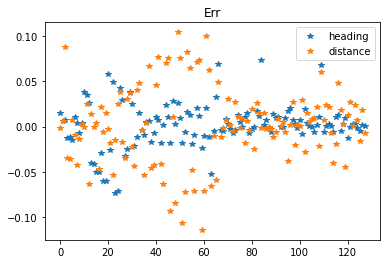

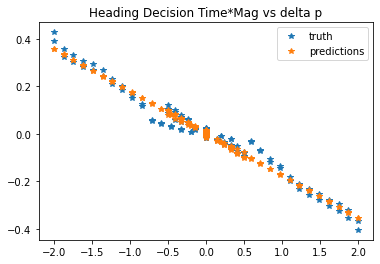

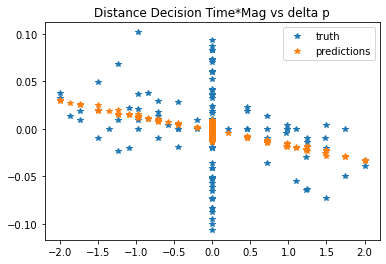

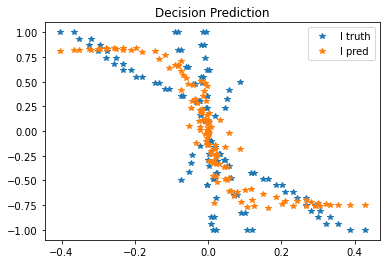

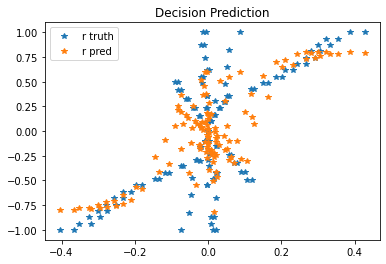

In [5]:
from matplotlib import pyplot as plt
import numpy as np


all_input_vectors=np.array(vmgyrus.all_input_vectors)
all_decision_vectors=np.array(vmgyrus.all_decision_vectors)
all_target_vectors=np.array(vmgyrus.all_target_vectors)


fig, ax = plt.subplots()
plt.title("decision")
ax.plot( all_decision_vectors,'*')
plt.show()

fig, ax = plt.subplots()
plt.title("input_vectors")
ax.plot( all_input_vectors,'*')
plt.show()

fig, ax = plt.subplots()
plt.title("input_vectors -heading")
ax.plot( all_input_vectors[:,0],'*')
plt.show()

fig, ax = plt.subplots()
plt.title("input_vectors -distance")
ax.plot( all_input_vectors[:,1],'*')
plt.show()

fig, ax = plt.subplots()
plt.title("target_vectors - heading")
ax.plot( all_target_vectors[:,0],'*')
plt.show()

fig, ax = plt.subplots()
plt.title("target_vectors - distance")
ax.plot( all_target_vectors[:,1],'*')
plt.show()

inputs,decisions,targets=vmgyrus.state_predictor.experience_memory.get_as_batches()
motion_out=vmgyrus.motionpredictor( torch.cat( (inputs,decisions),1 ))
decision_out=vmgyrus.policy( torch.cat( (inputs,targets),1))
motion_out=motion_out.detach().numpy()
decision_out=decision_out.detach().numpy()
inputs=inputs.detach().numpy()
decisions=decisions.detach().numpy()
targets=targets.detach().numpy()

fig, ax=plt.subplots()
plt.title("weights in memory")
plt.plot( [x[3] for x in vmgyrus.state_predictor.experience_memory.experiences],'*')
plt.show()

fig, ax = plt.subplots()
plt.title("inputs in memory")
ax.plot(inputs,'*')
plt.show()

fig, ax = plt.subplots()
plt.title("decisions in memory")
ax.plot(decisions,'*')
plt.show()

fig, ax = plt.subplots()
plt.title("targets in memory")
ax.plot(targets,'*')
plt.show()



fig, ax = plt.subplots()
plt.title("Motion Predictor Targets and Predictions")
ax.plot( targets[:],'*')
ax.plot( motion_out[:],'*')
plt.show()
          
fig, ax = plt.subplots()
plt.title("Decision Predictor Targets and Predictions")
ax.plot( decisions[:],'*')
ax.plot( decision_out[:],'*')
plt.show()


fig, ax = plt.subplots()
plt.title("Err")
ax.plot( targets[:,0]-motion_out[:,0],'*',label="heading")
ax.plot( targets[:,1]-motion_out[:,1],'*',label="distance")
plt.legend()
plt.show()

fig, ax = plt.subplots()
plt.title("Heading Decision Time*Mag vs delta p")
ax.plot( (decisions[:,0]-decisions[:,1]),targets[:,0],'*',label='truth')
ax.plot( (decisions[:,0]-decisions[:,1]),motion_out[:,0],'*',label='predictions')
plt.legend()
plt.show()

fig, ax = plt.subplots()
plt.title("Distance Decision Time*Mag vs delta p")
ax.plot( (decisions[:,0]+decisions[:,1]),targets[:,1],'*',label='truth')
ax.plot( (decisions[:,0]+decisions[:,1]),motion_out[:,1],'*',label='predictions')
plt.legend()
plt.show()

fig, ax = plt.subplots()
plt.title("Decision Prediction")
ax.plot( targets[:,0],decisions[:,0],'*',label='l truth')
ax.plot( targets[:,0],decision_out[:,0],'*',label='l pred')

#ax.plot( targets[:,0],decisions[:,0]-decisions[:,1],'*',label='lminusr truth')
#ax.plot( targets[:,0],decision_out[:,0]-decision_out[:,1],'*',label='lminusr pred')
plt.legend()
plt.show()

fig, ax = plt.subplots()
plt.title("Decision Prediction")
ax.plot( targets[:,0],decisions[:,1],'*',label='r truth')
ax.plot( targets[:,0],decision_out[:,1],'*',label='r pred')

#ax.plot( targets[:,0],decisions[:,0]-decisions[:,1],'*',label='lminusr truth')
#ax.plot( targets[:,0],decision_out[:,0]-decision_out[:,1],'*',label='lminusr pred')
plt.legend()
plt.show()


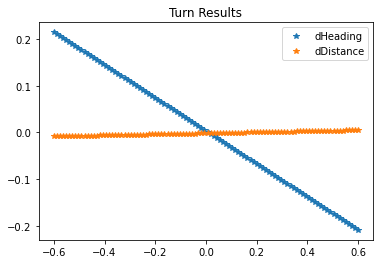

In [6]:
#let's make a plot of just heading changes and just distance changes presumably
#turns first
turn_inputs=[]
turn_outputs=[]
for t in np.linspace(-0.6,0.6,100):
    turn_inputs.append(t)
    input_vector=[0,1.0]
    decision=[ t,-t]    
    out=vmgyrus.state_predictor.predict_output(input_vector,decision)
    turn_outputs.append(out)
turn_outputs=np.array(turn_outputs)
    
fig, ax = plt.subplots()
plt.title("Turn Results")
ax.plot( turn_inputs,turn_outputs[:,0],'*',label="dHeading")
ax.plot( turn_inputs,turn_outputs[:,1],'*',label="dDistance")
plt.legend()
plt.show()


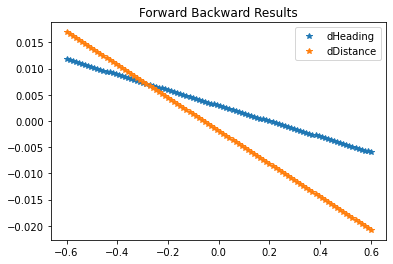

In [7]:
#now forward backward
turn_inputs=[]
turn_outputs=[]
for t in np.linspace(-0.6,0.6,100):
    turn_inputs.append(t)
    input_vector=[0,1.0]
    decision=[ t,t]
    out=vmgyrus.state_predictor.predict_output(input_vector,decision)
    turn_outputs.append(out)
turn_outputs=np.array(turn_outputs)
    
fig, ax = plt.subplots()
plt.title("Forward Backward Results")
ax.plot( turn_inputs,turn_outputs[:,0],'*',label="dHeading")
ax.plot( turn_inputs,turn_outputs[:,1],'*',label="dDistance")
plt.legend()
plt.show()

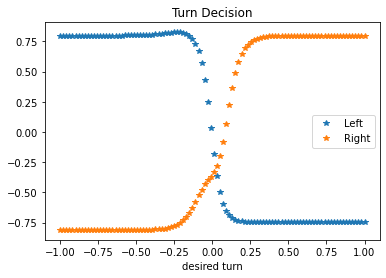

In [8]:
#Driving prediction
decisions=[]
turn_inputs=[]
for deltat in np.linspace(-1.0,1.0,100):
    input_state=[0,1.0]
    output_state=[deltat,0.0]
    decision=vmgyrus.state_predictor.predict_decision(input_state,output_state)
    decisions.append(decision)
    turn_inputs.append(deltat)
decisions=np.array(decisions)
    
fig, ax = plt.subplots()
plt.title("Turn Decision")
plt.xlabel("desired turn")
ax.plot( turn_inputs,decisions[:,0],'*',label="Left")
ax.plot( turn_inputs,decisions[:,1],'*',label="Right")
plt.legend()
plt.show()

In [9]:
vmgyrus.state_predictor.fantasy_train_policy()
vmgyrus.state_predictor.train()

training


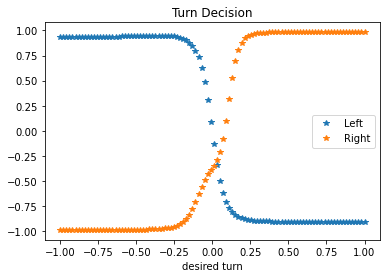

In [10]:
#Driving prediction
decisions=[]
turn_inputs=[]
for deltat in np.linspace(-1.0,1.0,100):
    input_state=[0,1.0]
    output_state=[deltat,0.0]
    decision=vmgyrus.state_predictor.predict_decision(input_state,output_state)
    decisions.append(decision)
    turn_inputs.append(deltat)
decisions=np.array(decisions)
    
fig, ax = plt.subplots()
plt.title("Turn Decision")
plt.xlabel("desired turn")
ax.plot( turn_inputs,decisions[:,0],'*',label="Left")
ax.plot( turn_inputs,decisions[:,1],'*',label="Right")
plt.legend()
plt.show()

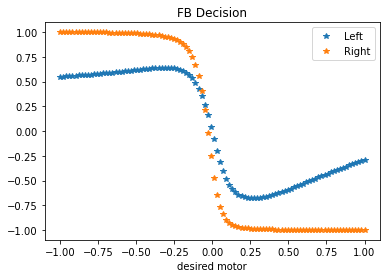

In [11]:
#Driving prediction
decisions=[]
turn_inputs=[]
for deltat in np.linspace(-1.0,1.0,100):
    input_state=[0,1.0]
    output_state=[0,deltat]
    decision=vmgyrus.state_predictor.predict_decision(input_state,output_state)
    decisions.append(decision)
    turn_inputs.append(deltat)
decisions=np.array(decisions)
    
fig, ax = plt.subplots()
plt.title("FB Decision")
plt.xlabel("desired motor")
ax.plot( turn_inputs,decisions[:,0],'*',label="Left")
ax.plot( turn_inputs,decisions[:,1],'*',label="Right")
plt.legend()
plt.show()